### HomeWork 1

Имеются данные adult.csv (см. в материалах к занятию)

Целевой переменной является уровень дохода income (крайний правый столбец).

Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from itertools import product

In [85]:
data = pd.read_csv('adult.csv')
data.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [86]:
data.shape

(48842, 15)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [88]:
#В df есть строки содержащие "?" они могут отрицательно повлиять на результат. Смотрю сколько их.

data[data.isin(['?'])].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                0 non-null float64
workclass          2799 non-null object
fnlwgt             0 non-null float64
education          0 non-null object
educational-num    0 non-null float64
marital-status     0 non-null object
occupation         2809 non-null object
relationship       0 non-null object
race               0 non-null object
gender             0 non-null object
capital-gain       0 non-null float64
capital-loss       0 non-null float64
hours-per-week     0 non-null float64
native-country     857 non-null object
income             0 non-null object
dtypes: float64(6), object(9)
memory usage: 5.6+ MB


In [89]:
#тут я смотрел уникальные занчения по всем столбца - знакомился с df
data['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

#### Попробуем угадать доход [income]

#### Выбрал признаки:
age, workclass, educational-num, race, gender, hours-per-week, native-country

На доход так же могут влиять 'marital-status', 'occupation', 'relationship', но, возможно, их влияние минимально, а их введение в можель сильно увеличит количество признаков. Я решил их исключить.

In [90]:
# выбираю признаки
selectedColumns = data[['age', 'workclass', 'educational-num', 'race', 'gender', 'hours-per-week', 'native-country' ]]

# столбецы workclass', 'race', 'gender','native-country' являются категориальными
# перевожу их в значения 0 и 1, добавив столбцы с соответствующими названиями
x = pd.get_dummies(selectedColumns, columns = ['workclass', 'race', 'gender','native-country'])
x.head()

,age,educational-num,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,50,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,10,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,30,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
# целевая переменная (столбец 'income') также является категориальной
# перевожу её значения столбца в числа

le = LabelEncoder()
le.fit(data['income'])
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [98]:
# записываю в переменную y преобразованный столбец income

y = pd.Series(data = le.transform(data['income']))
y.head(5)

0    0
1    0
2    1
3    1
4    0
dtype: int32

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
# обучаю модель
model = LogisticRegression(C = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [115]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      7479
           1       0.72      0.45      0.55      2290

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.82      0.83      0.81      9769



баланс между полнотой и точностью решается за счет predict_proba (решайте сами, какие ошибки вам дороже...)

In [116]:
y_pred_proba = model.predict_proba(X_test).tolist()

In [117]:
y_pred_proba[0]

[0.8940151476924703, 0.10598485230752974]

In [128]:
threshold = 0.9
y_pred_2 = [1 if y[1] > threshold else 0 for y in y_pred_proba]
print (classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      7479
           1       0.96      0.14      0.24      2290

    accuracy                           0.80      9769
   macro avg       0.88      0.57      0.56      9769
weighted avg       0.83      0.80      0.73      9769



Confusion matrix, without normalization
[[7071  408]
 [1261 1029]]


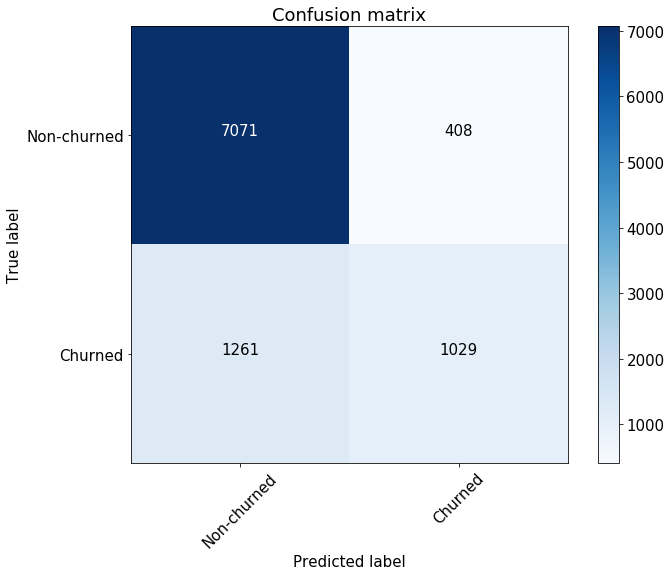

In [129]:
#код ниже взял с 
# https://habr.com/ru/company/ods/blog/328372/ 
# и подогнал :)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()